# Preparations

### Installation of [`Conda`](https://github.com/conda/conda)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

### Installation of [`ART`](https://github.com/Trusted-AI/adversarial-robustness-toolbox/) and [`Counterfit`](https://github.com/Azure/counterfit/)

In [2]:
!git clone https://github.com/Azure/counterfit.git
!cd counterfit; conda create --yes -n counterfit python=3.8.8; conda activate counterfit; pip install -r requirements.txt
!pip install sacremoses protobuf==3.20.*
!apt-get install libmagic-dev
!pip install python-magic

!pip install adversarial-robustness-toolbox

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

# Assume that we have a black-box classification model called `model`
model = load_model('/content/counterfit/counterfit/targets/digits_keras/mnist_model.h5')
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])


In [4]:
from art.estimators.classification import KerasClassifier

# Creation of the ART classifier with a pretrained model
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0), use_logits=False)

In [5]:
from art.utils import load_mnist

#Getting test data
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Model inversion attack

In [7]:
from art.attacks.inference.model_inversion import MIFace

x_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

attackInversion = MIFace(classifier)
inverted = attackInversion.infer(x_average, y=np.arange(10))

Model inversion: 100%|▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬|10/10 [10:13<00:00, 61.38s/it]


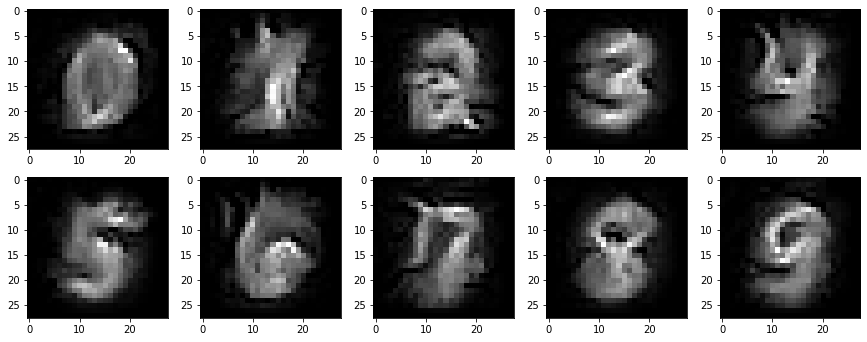

In [8]:
import matplotlib.pyplot as plt

# Retrieved data samples
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(inverted[i,], (28, 28))), cmap=plt.cm.gray)

# Model extraction attack

In [9]:
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential

# Creation of a simple, empty model
modelSimple = Sequential()
modelSimple.add(Conv2D(1, kernel_size=(8, 8), activation="relu", input_shape=(28, 28, 1)))
modelSimple.add(MaxPooling2D(pool_size=(5, 5)))
modelSimple.add(Flatten())
modelSimple.add(Dense(10, activation="softmax"))
modelSimple.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

res = KerasClassifier(modelSimple, clip_values=(0, 1), use_logits=False)

In [10]:
from art.attacks.extraction import CopycatCNN

# Training a substitute model based on the target model
attackExtraction = CopycatCNN(classifier, batch_size_fit=10, batch_size_query=10, nb_epochs=10, nb_stolen=100)
extracted = attackExtraction.extract(x_test, thieved_classifier=res)

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 0s 2ms/sample - loss: 2.2616 - accuracy: 0.1500
Epoch 2/10
100/100 [==============================] - 0s 740us/sample - loss: 2.0509 - accuracy: 0.2600
Epoch 3/10
100/100 [==============================] - 0s 658us/sample - loss: 1.7601 - accuracy: 0.4600
Epoch 4/10
100/100 [==============================] - 0s 658us/sample - loss: 1.4344 - accuracy: 0.5800
Epoch 5/10
100/100 [==============================] - 0s 702us/sample - loss: 1.1608 - accuracy: 0.6700
Epoch 6/10
100/100 [==============================] - 0s 707us/sample - loss: 0.9168 - accuracy: 0.7400
Epoch 7/10
100/100 [==============================] - 0s 804us/sample - loss: 0.7963 - accuracy: 0.7500
Epoch 8/10
100/100 [==============================] - 0s 700us/sample - loss: 0.6875 - accuracy: 0.7900
Epoch 9/10
100/100 [==============================] - 0s 570us/sample - loss: 0.6211 - accuracy: 0.8100
Epoch 10/10
100/100 [========================

In [11]:
# Making predictions with use of both original and extracted versions of the target model and evaluating their similarity
victim_predictions = np.argmax(model.predict(x_test), axis=1)
thieved_predictions = np.argmax(extracted.predict(x_test), axis=1)
accuracy = np.sum(victim_predictions == thieved_predictions) / len(victim_predictions)

print(f"Similarity of predictions: {accuracy * 100} %")

Similarity of predictions: 69.31 %


# Evasion attack

### With use of Adversarial Robustness Toolbox

In [12]:
from art.attacks.evasion import FastGradientMethod

# Generation of adversarial examples
attackEvasion = FastGradientMethod(estimator=classifier, eps=0.2, batch_size=64)
x_adv = attackEvasion.generate(x_test)

# Predicting and evaluating accuracies of predictions on both initial data samples and adversarial ones
predictions = (classifier.predict(x_test), classifier.predict(x_adv))
accuracies = (np.sum(np.argmax(predictions[0], axis=1) == np.argmax(y_test, axis=1)) / len(y_test),
            np.sum(np.argmax(predictions[1], axis=1) == np.argmax(y_test, axis=1)) / len(y_test))

print(f"Accuracy of predictions (initial data): {accuracies[0] * 100} %")
print(f"Accuracy of predictions  (adversarial): {accuracies[1] * 100} %")

Accuracy of predictions (initial data): 98.16 %
Accuracy of predictions  (adversarial): 41.88 %


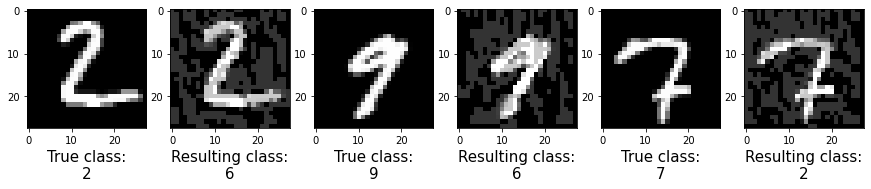

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
n = 0

# Comparison of samples from the initial dataset and their adversarial twins
for i in [1,20,36]:
  initPrediction = classifier.predict([x_test[i]])[0]
  initPrediction = np.where(np.isclose(initPrediction, max(initPrediction)))[0][0]
  plt.subplot(1, 6, n + 1)
  plt.xlabel(f"True class:\n{initPrediction}", size=15)
  plt.imshow( (np.reshape(x_test[0+i,], (28, 28))), cmap=plt.cm.gray)

  advPrediction  = classifier.predict([ x_adv[i]])[0]
  advPrediction  = np.where(np.isclose(advPrediction,  max(advPrediction )))[0][0]
  plt.subplot(1, 6, n + 2)
  plt.xlabel(f"Resulting class:\n{advPrediction}", size=15)
  plt.imshow( (np.reshape(x_adv[0+i,], (28, 28))), cmap=plt.cm.gray)
  
  n += 2

### With use of Countfit

Demonstration of Counterfit features
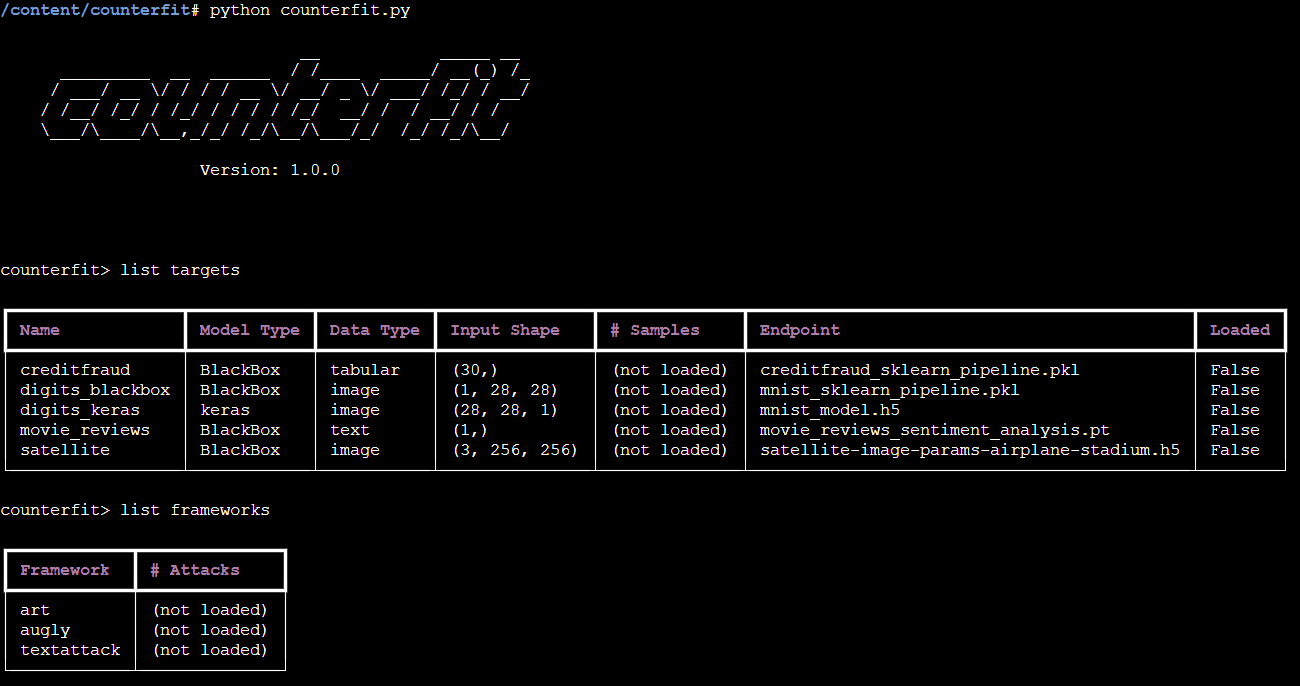
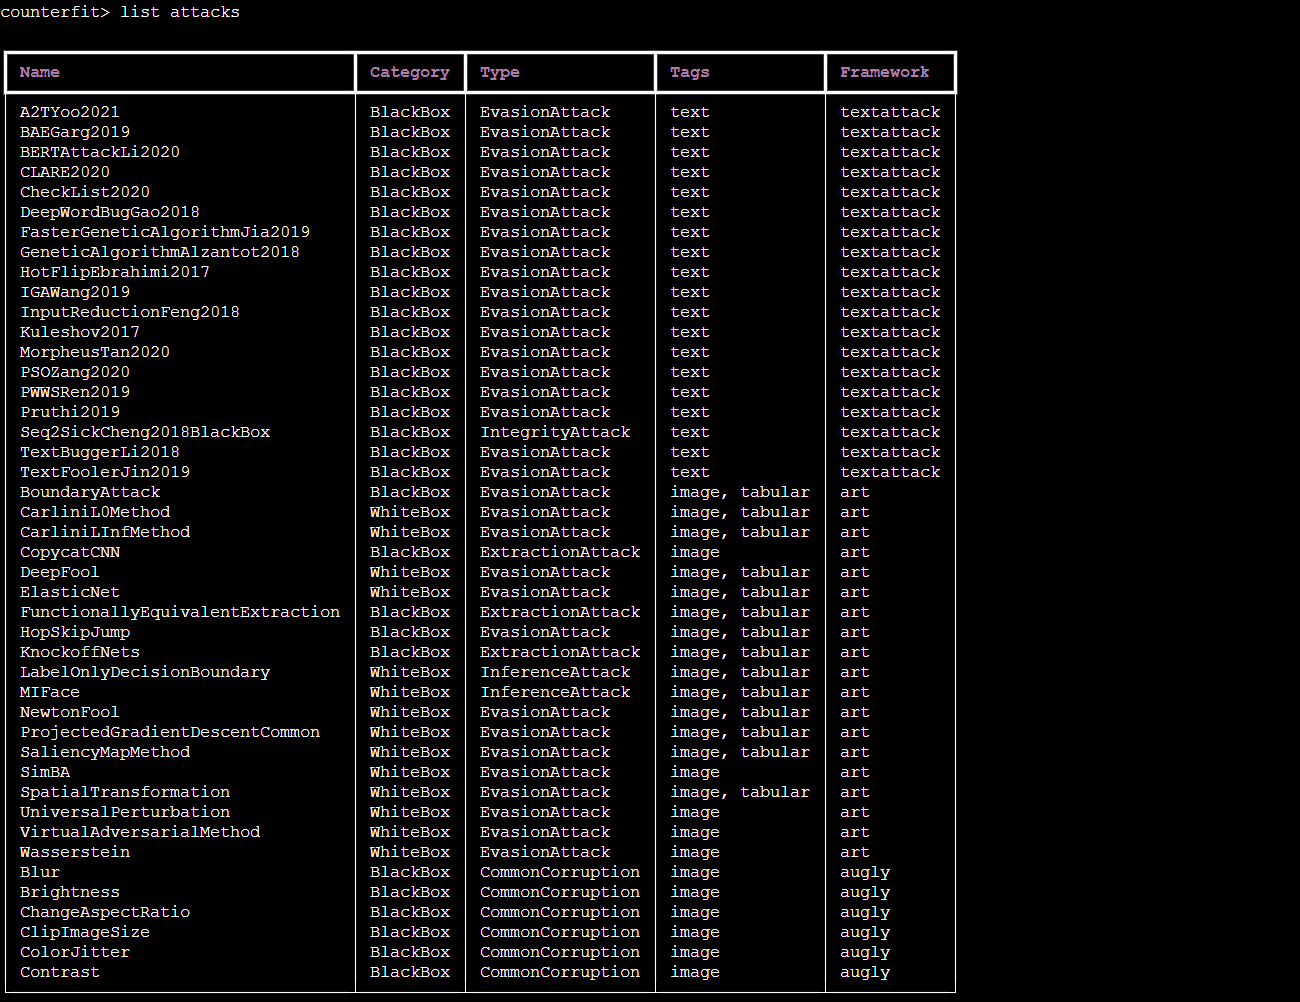

**Evasion attack example**<br>
Loading the black-box model called `digits_blackbox`, making predictions on test data:
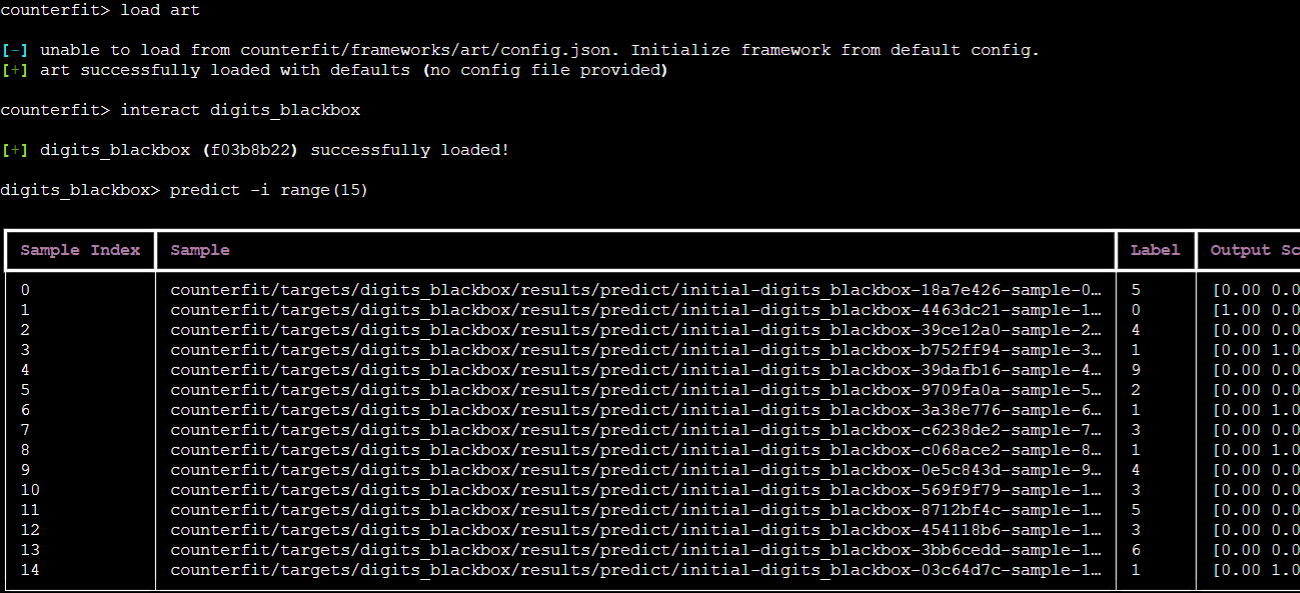<br><br>
- Generation of adversarial examples out of test sample with index `1` (true class=`0`, resulting class=`6`):
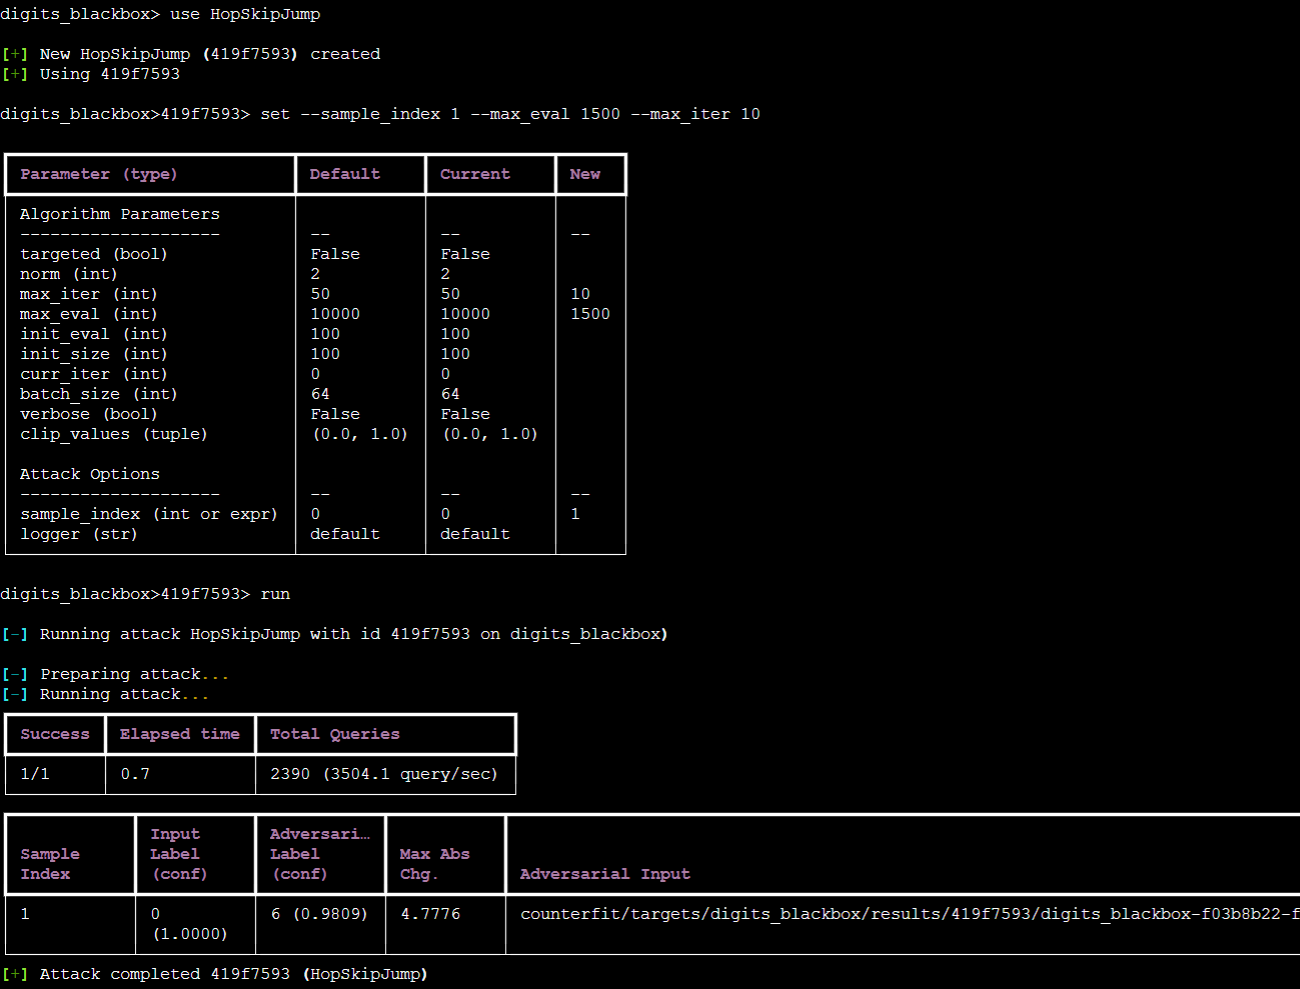<br><br>
- Generation of adversarial examples out of test sample with index `3` (true class=`1`, resulting class=`8`):
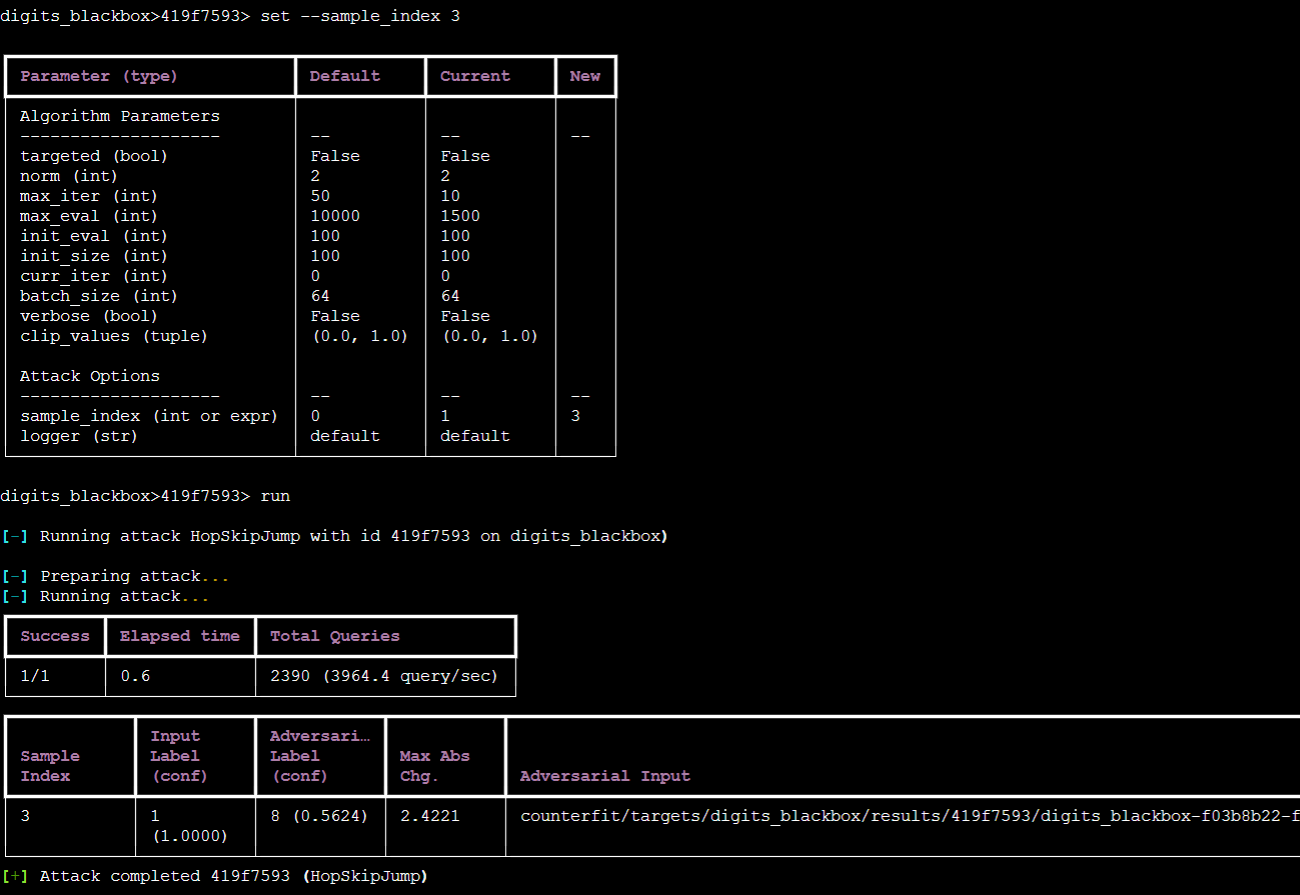<br><br>
- Generation of adversarial examples out of test sample with index `5` (true class=`2`, resulting class=`4`):
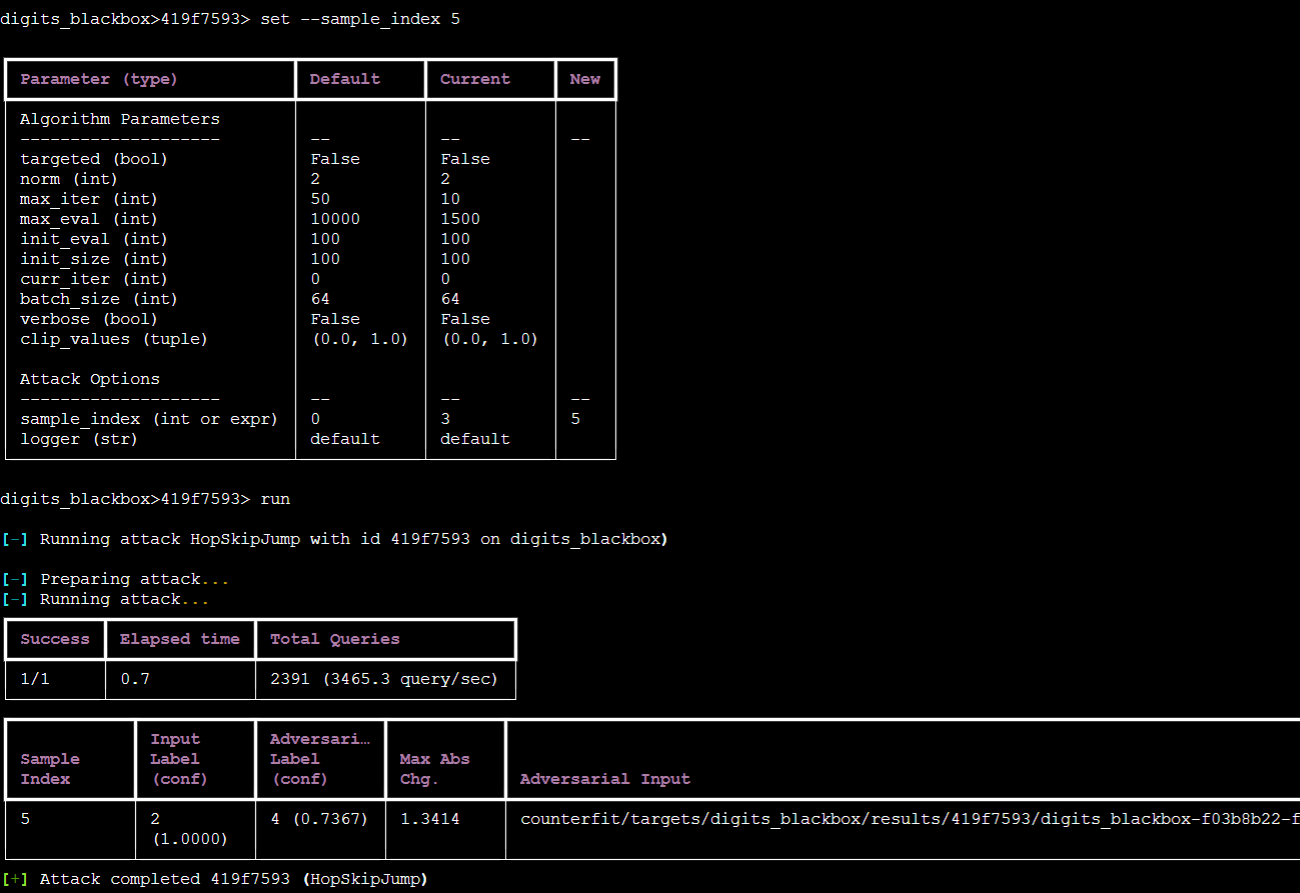

- `Sample 1`: Before (Class `0`) & after (Class `6`)<br>



- `Sample 3`: Before (Class `1`) & after (Class `8`)<br>



- `Sample 5`: Before (Class `2`) & after (Class `4`)<br>

